# Poisson Noise Treatment

In [229]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import skimage
# from skimage.util import random_noise

<class 'numpy.ndarray'>
(2494, 2048, 3)
<class 'numpy.uint8'>
The x dimension is 2048, the y dim is 2494 and the number of channels is 3


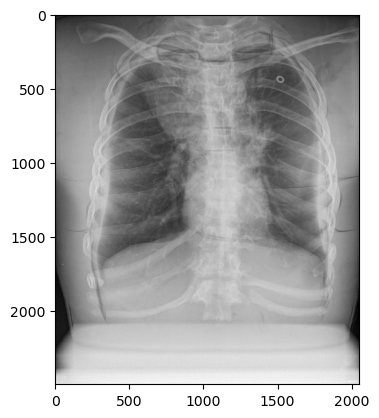

In [230]:
img_location: str = '../images/img_2048x2494x15.jpg'
img = cv.imread(img_location)
plt.imshow(img)
# we get the resolution and number of channels
print(type(img))
print(img.shape)
print(type(img[0, 0, 0]))
nrow, ncol, nch = img.shape
print(f"The x dimension is {ncol}, the y dim is {nrow} and the number of channels is {nch}")
plt.show()

- **NOTE**: The image has some extra pixels in the y-axis. Before proceeding we crop it.

(2048, 2048, 3)


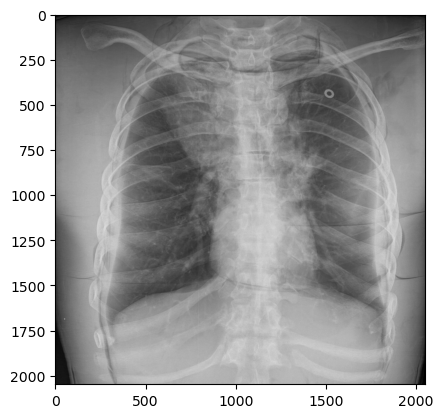

[0 0 0]
[81 81 81]
204


In [231]:
cropped_img = img[0:2048,:,:]
cv.imwrite('../images/c_img.jpg', cropped_img)
plt.imshow(cropped_img)
print(cropped_img.shape)
plt.show()
print(cropped_img[0, 0])
print(cropped_img[600, 500])
print(max(cropped_img[2000, :, 0]))

## Adding Poisson Noise

### Poisson Distribution Review
- The Poisson distribution has the following form:
$$f(k;\lambda) = \frac{\lambda^ke^{-\lambda}}{k!},$$
- where, $k$ is the light intensity (number of photons per unit of time measured) and $\lambda$ is the expected value which is also its variance.

In [232]:
def _convert(image, dtype, force_copy=False, uniform=False):
    image = np.asarray(image)
    dtypeobj_in = image.dtype
    if dtype is np.floating:
        dtypeobj_out = np.dtype('float64')
    else:
        dtypeobj_out = np.dtype(dtype)
    dtype_in = dtypeobj_in.type
    dtype_out = dtypeobj_out.type
    kind_in = dtypeobj_in.kind
    kind_out = dtypeobj_out.kind
    itemsize_in = dtypeobj_in.itemsize
    itemsize_out = dtypeobj_out.itemsize

    # Below, we do an `issubdtype` check.  Its purpose is to find out
    # whether we can get away without doing any image conversion.  This happens
    # when:
    #
    # - the output and input dtypes are the same or
    # - when the output is specified as a type, and the input dtype
    #   is a subclass of that type (e.g. `np.floating` will allow
    #   `float32` and `float64` arrays through)

    if np.issubdtype(dtype_in, np.obj2sctype(dtype)):
        if force_copy:
            image = image.copy()
        return image

    if not (dtype_in in _supported_types and dtype_out in _supported_types):
        raise ValueError(f'Cannot convert from {dtypeobj_in} to '
                         f'{dtypeobj_out}.')

    if kind_in in 'ui':
        imin_in = np.iinfo(dtype_in).min
        imax_in = np.iinfo(dtype_in).max
    if kind_out in 'ui':
        imin_out = np.iinfo(dtype_out).min
        imax_out = np.iinfo(dtype_out).max

    # any -> binary
    if kind_out == 'b':
        return image > dtype_in(dtype_range[dtype_in][1] / 2)

    # binary -> any
    if kind_in == 'b':
        result = image.astype(dtype_out)
        if kind_out != 'f':
            result *= dtype_out(dtype_range[dtype_out][1])
        return result

    # float -> any
    if kind_in == 'f':
        if kind_out == 'f':
            # float -> float
            return image.astype(dtype_out)

        if np.min(image) < -1.0 or np.max(image) > 1.0:
            raise ValueError("Images of type float must be between -1 and 1.")
        # floating point -> integer
        # use float type that can represent output integer type
        computation_type = _dtype_itemsize(itemsize_out, dtype_in,
                                           np.float32, np.float64)

        if not uniform:
            if kind_out == 'u':
                image_out = np.multiply(image, imax_out,
                                        dtype=computation_type)
            else:
                image_out = np.multiply(image, (imax_out - imin_out) / 2,
                                        dtype=computation_type)
                image_out -= 1.0 / 2.
            np.rint(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        elif kind_out == 'u':
            image_out = np.multiply(image, imax_out + 1,
                                    dtype=computation_type)
            np.clip(image_out, 0, imax_out, out=image_out)
        else:
            image_out = np.multiply(image, (imax_out - imin_out + 1.0) / 2.0,
                                    dtype=computation_type)
            np.floor(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        return image_out.astype(dtype_out)

    # signed/unsigned int -> float
    if kind_out == 'f':
        # use float type that can exactly represent input integers
        computation_type = _dtype_itemsize(itemsize_in, dtype_out,
                                           np.float32, np.float64)

        if kind_in == 'u':
            # using np.divide or np.multiply doesn't copy the data
            # until the computation time
            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            # DirectX uses this conversion also for signed ints
            # if imin_in:
            #     np.maximum(image, -1.0, out=image)
        elif kind_in == 'i':
            # From DirectX conversions:
            # The most negative value maps to -1.0f
            # Every other value is converted to a float (call it c)
            # and then result = c * (1.0f / (2⁽ⁿ⁻¹⁾-1)).

            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            np.maximum(image, -1.0, out=image)

        else:
            image = np.add(image, 0.5, dtype=computation_type)
            image *= 2 / (imax_in - imin_in)

        return np.asarray(image, dtype_out)

    # unsigned int -> signed/unsigned int
    if kind_in == 'u':
        if kind_out == 'i':
            # unsigned int -> signed int
            image = _scale(image, 8 * itemsize_in, 8 * itemsize_out - 1)
            return image.view(dtype_out)
        else:
            # unsigned int -> unsigned int
            return _scale(image, 8 * itemsize_in, 8 * itemsize_out)

    # signed int -> unsigned int
    if kind_out == 'u':
        image = _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out)
        result = np.empty(image.shape, dtype_out)
        np.maximum(image, 0, out=result, dtype=image.dtype, casting='unsafe')
        return result

    # signed int -> signed int
    if itemsize_in > itemsize_out:
        return _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out - 1)

    image = image.astype(_dtype_bits('i', itemsize_out * 8))
    image -= imin_in
    image = _scale(image, 8 * itemsize_in, 8 * itemsize_out, copy=False)
    image += imin_out
    return image.astype(dtype_out)

In [233]:
import numpy as np
from warnings import warn


__all__ = ['img_as_float32', 'img_as_float64', 'img_as_float',
           'img_as_int', 'img_as_uint', 'img_as_ubyte',
           'img_as_bool', 'dtype_limits']

# For integers Numpy uses `_integer_types` basis internally, and builds a leaky
# `np.XintYY` abstraction on top of it. This leads to situations when, for
# example, there are two np.Xint64 dtypes with the same attributes but
# different object references. In order to avoid any potential issues,
# we use the basis dtypes here. For more information, see:
# - https://github.com/scikit-image/scikit-image/issues/3043
# For convenience, for these dtypes we indicate also the possible bit depths
# (some of them are platform specific). For the details, see:
# http://www.unix.org/whitepapers/64bit.html
_integer_types = (np.byte, np.ubyte,          # 8 bits
                  np.short, np.ushort,        # 16 bits
                  np.intc, np.uintc,          # 16 or 32 or 64 bits
                  int, np.int_, np.uint,      # 32 or 64 bits
                  np.longlong, np.ulonglong)  # 64 bits
_integer_ranges = {t: (np.iinfo(t).min, np.iinfo(t).max)
                   for t in _integer_types}
dtype_range = {bool: (False, True),
               np.bool_: (False, True),
               np.bool8: (False, True),
               float: (-1, 1),
               np.float_: (-1, 1),
               np.float16: (-1, 1),
               np.float32: (-1, 1),
               np.float64: (-1, 1)}
dtype_range.update(_integer_ranges)

_supported_types = list(dtype_range.keys())


def _convert(image, dtype, force_copy=False, uniform=False):
    image = np.asarray(image)
    dtypeobj_in = image.dtype
    if dtype is np.floating:
        dtypeobj_out = np.dtype('float64')
    else:
        dtypeobj_out = np.dtype(dtype)
    dtype_in = dtypeobj_in.type
    dtype_out = dtypeobj_out.type
    kind_in = dtypeobj_in.kind
    kind_out = dtypeobj_out.kind
    itemsize_in = dtypeobj_in.itemsize
    itemsize_out = dtypeobj_out.itemsize

    # Below, we do an `issubdtype` check.  Its purpose is to find out
    # whether we can get away without doing any image conversion.  This happens
    # when:
    #
    # - the output and input dtypes are the same or
    # - when the output is specified as a type, and the input dtype
    #   is a subclass of that type (e.g. `np.floating` will allow
    #   `float32` and `float64` arrays through)

    if np.issubdtype(dtype_in, np.obj2sctype(dtype)):
        if force_copy:
            image = image.copy()
        return image

    if not (dtype_in in _supported_types and dtype_out in _supported_types):
        raise ValueError(f'Cannot convert from {dtypeobj_in} to '
                         f'{dtypeobj_out}.')

    if kind_in in 'ui':
        imin_in = np.iinfo(dtype_in).min
        imax_in = np.iinfo(dtype_in).max
    if kind_out in 'ui':
        imin_out = np.iinfo(dtype_out).min
        imax_out = np.iinfo(dtype_out).max

    # any -> binary
    if kind_out == 'b':
        return image > dtype_in(dtype_range[dtype_in][1] / 2)

    # binary -> any
    if kind_in == 'b':
        result = image.astype(dtype_out)
        if kind_out != 'f':
            result *= dtype_out(dtype_range[dtype_out][1])
        return result

    # float -> any
    if kind_in == 'f':
        if kind_out == 'f':
            # float -> float
            return image.astype(dtype_out)

        if np.min(image) < -1.0 or np.max(image) > 1.0:
            raise ValueError("Images of type float must be between -1 and 1.")
        # floating point -> integer
        # use float type that can represent output integer type
        computation_type = _dtype_itemsize(itemsize_out, dtype_in,
                                           np.float32, np.float64)

        if not uniform:
            if kind_out == 'u':
                image_out = np.multiply(image, imax_out,
                                        dtype=computation_type)
            else:
                image_out = np.multiply(image, (imax_out - imin_out) / 2,
                                        dtype=computation_type)
                image_out -= 1.0 / 2.
            np.rint(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        elif kind_out == 'u':
            image_out = np.multiply(image, imax_out + 1,
                                    dtype=computation_type)
            np.clip(image_out, 0, imax_out, out=image_out)
        else:
            image_out = np.multiply(image, (imax_out - imin_out + 1.0) / 2.0,
                                    dtype=computation_type)
            np.floor(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        return image_out.astype(dtype_out)

    # signed/unsigned int -> float
    if kind_out == 'f':
        # use float type that can exactly represent input integers
        computation_type = _dtype_itemsize(itemsize_in, dtype_out,
                                           np.float32, np.float64)

        if kind_in == 'u':
            # using np.divide or np.multiply doesn't copy the data
            # until the computation time
            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            # DirectX uses this conversion also for signed ints
            # if imin_in:
            #     np.maximum(image, -1.0, out=image)
        elif kind_in == 'i':
            # From DirectX conversions:
            # The most negative value maps to -1.0f
            # Every other value is converted to a float (call it c)
            # and then result = c * (1.0f / (2⁽ⁿ⁻¹⁾-1)).

            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            np.maximum(image, -1.0, out=image)

        else:
            image = np.add(image, 0.5, dtype=computation_type)
            image *= 2 / (imax_in - imin_in)

        return np.asarray(image, dtype_out)

    # unsigned int -> signed/unsigned int
    if kind_in == 'u':
        if kind_out == 'i':
            # unsigned int -> signed int
            image = _scale(image, 8 * itemsize_in, 8 * itemsize_out - 1)
            return image.view(dtype_out)
        else:
            # unsigned int -> unsigned int
            return _scale(image, 8 * itemsize_in, 8 * itemsize_out)

    # signed int -> unsigned int
    if kind_out == 'u':
        image = _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out)
        result = np.empty(image.shape, dtype_out)
        np.maximum(image, 0, out=result, dtype=image.dtype, casting='unsafe')
        return result

    # signed int -> signed int
    if itemsize_in > itemsize_out:
        return _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out - 1)

    image = image.astype(_dtype_bits('i', itemsize_out * 8))
    image -= imin_in
    image = _scale(image, 8 * itemsize_in, 8 * itemsize_out, copy=False)
    image += imin_out
    return image.astype(dtype_out)




def img_as_float(image, force_copy=False):
    """Convert an image to floating point format.

    This function is similar to `img_as_float64`, but will not convert
    lower-precision floating point arrays to `float64`.

    Parameters
    ----------
    image : ndarray
        Input image.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.

    Returns
    -------
    out : ndarray of float
        Output image.

    Notes
    -----
    The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] when
    converting from unsigned or signed datatypes, respectively.
    If the input image has a float type, intensity values are not modified
    and can be outside the ranges [0.0, 1.0] or [-1.0, 1.0].

    """
    return _convert(image, np.floating, force_copy)

In [234]:
def random_noises(image, clip=True, **kwargs):
    image = img_as_float(image)

    rng = np.random.default_rng()


    # Determine unique values in image & calculate the next power of two
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))

    # Generating noise for each unique value in image.
    out = rng.poisson(image * vals) / float(vals)

    # Return image to original range if input was signed

    # Clip back to original range, if necessary
    if clip:
        out = np.clip(out, 0, 1.0)

    return out
# def apply_poisson_noise(img) -> np.ndarray:
#     is_signed: bool = False
#     if img.min() < 0:
#         print("The pixel values have negative numbers!")
#         is_signed = True
#     else:
#         print("The pixel values don't have negative numbers!")
#     img_float = img.astype(float)
#     rng = np.random.default_rng()
#     n_diff_events = len(np.unique(img))
#     b2n_events = 2 ** np.ceil(np.log2(n_diff_events))
#     if is_signed:
#         max_value = img.max()
#         img = (img + 1.) / (max_value + 1.)
#     pre_processed_img = rng.poisson(img_float * b2n_events) / float(b2n_events)
#     if is_signed:
#         pre_processed_img = pre_processed_img * (max_value + 1.) - 1.
#     return pre_processed_img

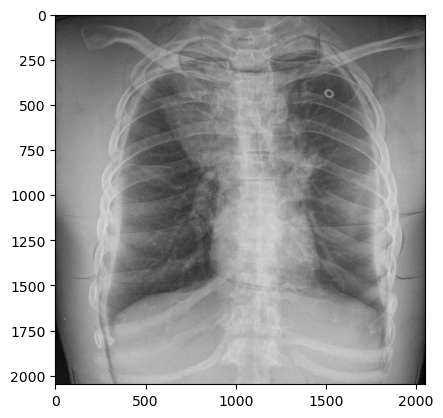

In [235]:
# img_with_applied_poisson_noise = apply_poisson_noise(cropped_img)
img_with_applied_poisson_noise = random_noises(cropped_img, mode='poisson')
plt.imshow(img_with_applied_poisson_noise)
plt.show()

(2048, 2048, 3)
228
256.0
256.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 2048, 3)


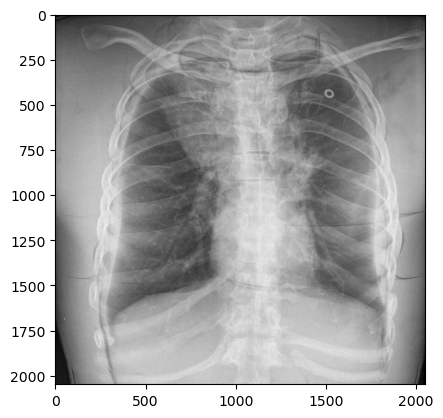

In [159]:
# rng = np.random.default_rng()
# print(cropped_img)
# print(cropped_img.shape)
# vals = len(np.unique(cropped_img))
# print(vals)
# vals = 2 ** np.ceil(np.log2(vals))
# print(vals)
# print(float(vals))
# old_max = cropped_img.max()
# cropped_img2 = (cropped_img + 1.) / (old_max + 1.)
# out = rng.poisson(cropped_img2 * vals) / float(vals)
# print(out.shape)
# plt.imshow(out)
# plt.show()
# def apply_poison_noise(image):
#     rng = np.random.default_rng()
#     vals = len(np.unique(image))
#     vals = 2 ** np.ceil(np.log2(vals))
#     noisy_img = rng.poisson(image * vals) / float(vals)
#     return noisy_img
# various lambdas (expected number of photons arrived over a time interval)
# lambdas: list = [1, 4, 7, 10]
# for lbd in lambdas:
#     img_with_noise = np.random.poisson(lbd, cropped_img)
#     new_name: str = 'cp' + 'lambda_' + str(lbd) + '_img.jpg'
#     cv.imwrite(new_name, img_with_noise)
#     plt.imshow(img_with_noise)
#     plt.show()
# poisson_noise = np.random.poisson(cropped_img)
# cv.imwrite('../images/cp_img.jpg', poisson_noise)
# plt.imshow(poisson_noise)
# plt.show()

# References:
1. [the ai codes](https://theai.codes/computer-vision/a-list-of-the-most-useful-opencv-filters/) Some useful opencv filters.
2. [noise scikit-image-utils](https://github.com/scikit-image/scikit-image/blob/417104097a0d4b5c3500bd05cf32fbdacee895ee/skimage/util/noise.py#L135) Some methods to generate noisy from the `scikit-image` module.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<class 'numpy.ndarray'>


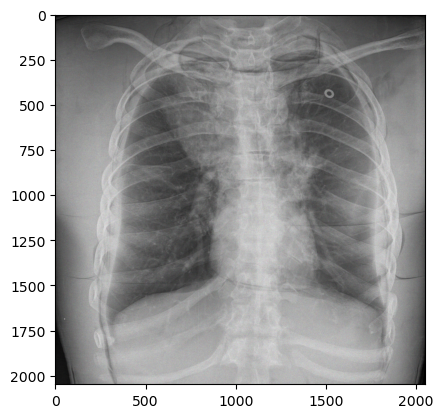

In [157]:
noisy_peixe = random_noise(cropped_img, mode="poisson")
print(type(noisy_peixe))
skimage.io.imsave('../images/skimage.jpg', noisy_peixe)
plt.imshow(noisy_peixe)
plt.show()